In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, accuracy_score

c:\Users\Ariel\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
c:\Users\Ariel\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [5]:
df_train = pd.read_csv('data/train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


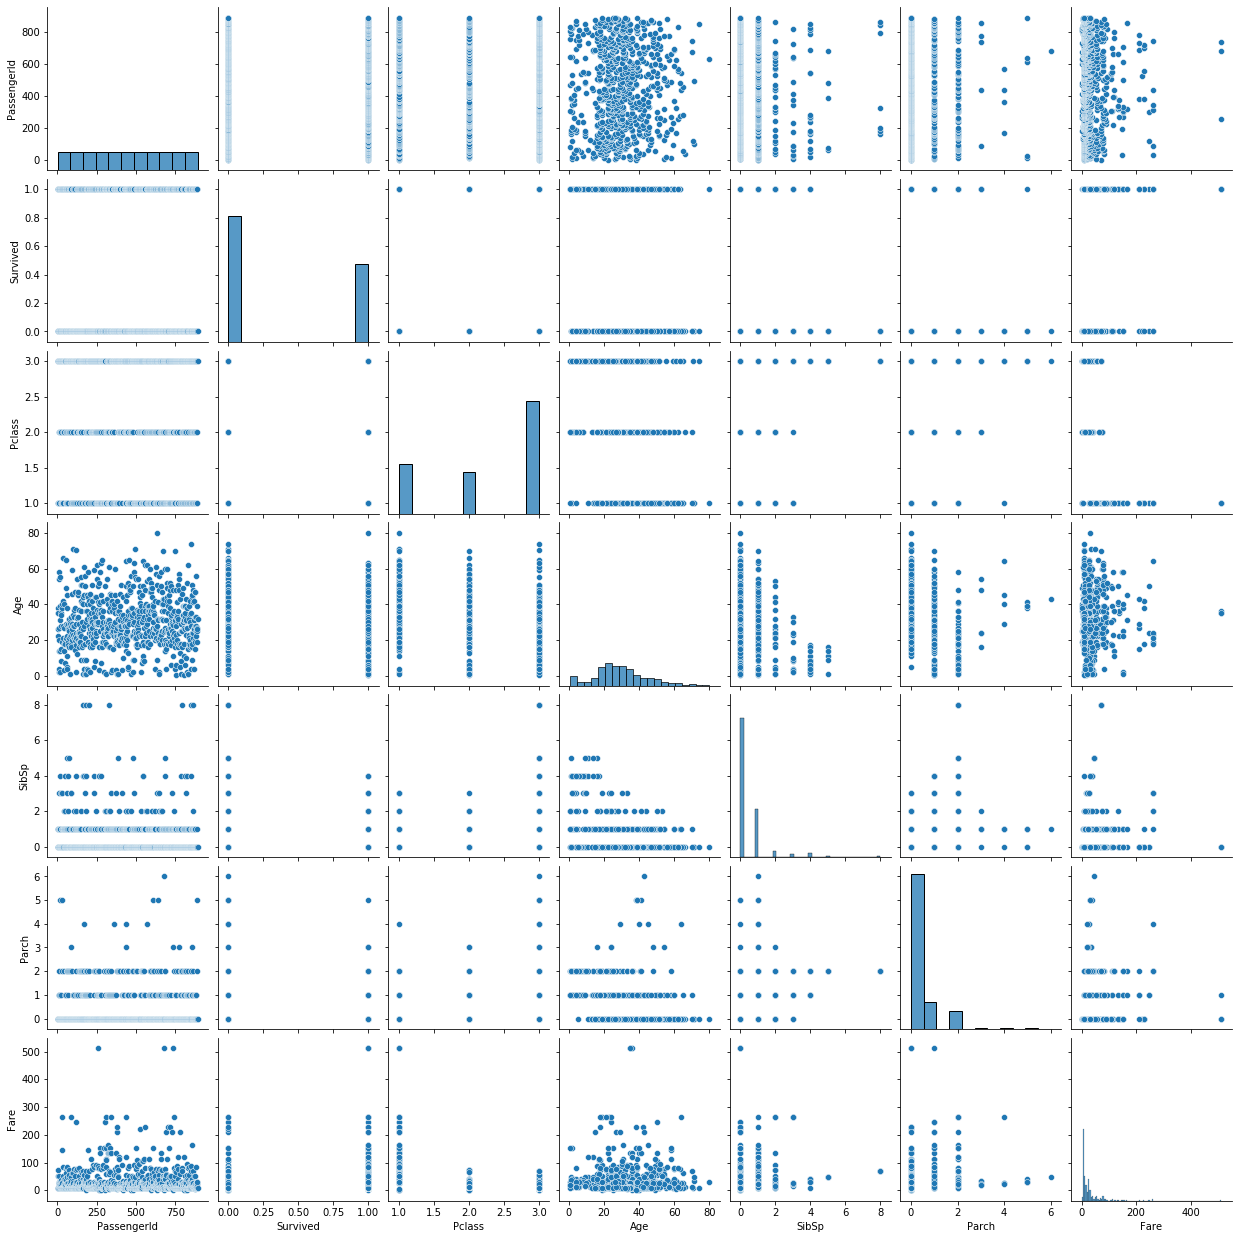

In [6]:
sns.pairplot(df_train)

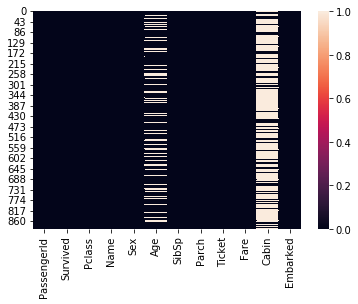

In [7]:
sns.heatmap(df_train.isna())

# Data Cleaning

- Drop `PassengerId`, `Ticket`, and `Cabin`
- Impute + normalize `Age`
- Deal with titles in `Name`
- Normalize `Fare`
- One-hot encoding for `Embarked`, 'Sex'
- Interaction variable between `Sex` and `Parch`
- Interaction variable between `SibSp` and `Parch`
- Interaction variable between `Sex` and `Pclass`
- Interaction variable between `Sex` and `Fare`

In [16]:
# Analysis for imputing age
title_dict = {
    "Capt": "Officer","Col": "Officer","Major": "Officer","Jonkheer": "Royalty", \
        "Don": "Royalty", "Sir" : "Royalty","Dr": "Royalty","Rev": "Royalty", \
        "Countess":"Royalty", "Mme": "Mrs", "Mlle": "Miss", "Ms": "Mrs","Mr" : "Mr", \
        "Mrs" : "Mrs","Miss" : "Miss","Master" : "Master","Lady" : "Royalty", "Dona": "Royalty"
}
df_train['Title_raw'] = df_train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df_train['Title'] = df_train.Title_raw.map(title_dict)
df_train['Has_Parents'] = df_train.Parch != 0
df_train['Paid_Fare'] = df_train.Fare != 0

df_train.groupby(['Sex', 'Pclass', 'Title', 'Embarked', 'Has_Parents', 'Paid_Fare']).Age.agg(['mean', 'count'])

mean  count
Sex    Pclass Title Embarked Has_Parents Paid_Fare                  
female 1      Miss  C        False       True       35.411765     17
                             True        True       23.200000      5
                    Q        False       True       33.000000      1
                    S        False       True       32.416667     12
                             True        True       20.000000     11
...                                                       ...    ...
male   3      Mr    Q        False       True       37.000000      9
                             True        True       40.000000      1
                    S        False       False      32.250000      4
                                         True       28.502841    176
                             True        True       27.906250     16

[66 rows x 2 columns]

In [86]:
def clean_data(data, impute=True):
    """
    Function for cleaning data
    """

    data_return = data.copy()

    # Titles
    title_dict = {
        "Capt": "Officer","Col": "Officer","Major": "Officer","Jonkheer": "Royalty", \
            "Don": "Royalty", "Sir" : "Royalty","Dr": "Royalty","Rev": "Royalty", \
            "Countess":"Royalty", "Mme": "Mrs", "Mlle": "Miss", "Ms": "Mrs","Mr" : "Mr", \
            "Mrs" : "Mrs","Miss" : "Miss","Master" : "Master","Lady" : "Royalty", "Dona": "Royalty"
    }
    data_return['Title_raw'] = data_return.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    data_return['Title'] = data_return.Title_raw.map(title_dict)

    # One-hot encoding for Title
    Title = pd.get_dummies(data_return.Title, prefix='Title')
    for col in Title.columns.sort_values()[1:]:
        data_return[col] = Title[col]

    # Normalize Fare
    data_return.Fare = data_return.Fare.replace(np.NaN, data_return.Fare.mean())
    data_return.Fare = (data_return.Fare - data_return.Fare.mean()) / data_return.Fare.std()

    # One-hot encoding for Embarked
    Embarked = pd.get_dummies(data_return.Embarked, prefix='Embarked')
    for col in Embarked.columns.sort_values()[1:]:
        data_return[col] = Embarked[col]

    # One-hot encoding for Sex
    Sex = pd.get_dummies(data_return.Sex, prefix='Sex')
    for col in Sex.columns.sort_values()[1:]:
        data_return[col] = Sex[col]

    # Interaction variables
    data_return['Sex_and_Parch'] = data_return.Sex_male * data_return.Parch
    data_return['SibSp_and_Parch'] = data_return.SibSp * data_return.Parch
    data_return['Sex_and_Pclass'] = data_return.Sex_male * data_return.Pclass
    data_return['Sex_and_Fare'] = data_return.Sex_male * data_return.Fare
    
    # Impute + normalize Age
    if impute:
        data_return.Age = data_return.Age.replace(np.NaN, data_return.Age.mean())
        data_return.Age = (data_return.Age - data_return.Age.mean()) / data_return.Age.std()
    else:
        data_return = data_return[data_return.Age.notna()]

    # Drop columns
    dropped_columns = [
        'PassengerId',
        'Ticket',
        'Cabin',
        'Name',
        'Title_raw',
        'Title',
        'Sex',
        # 'Has_Parents',
        # 'Paid_Fare',
        'Embarked'
    ]

    data_return.drop(dropped_columns, axis=1, inplace=True)

    return data_return

In [51]:
df_train_cleaned = clean_data(df_train)
df_train_cleaned.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_Q,Embarked_S,Sex_male,Sex_and_Parch,SibSp_and_Parch,Sex_and_Pclass,Sex_and_Fare
0,0,3,-0.592148,1,0,-0.502163,0,1,0,0,0,0,1,1,0,0,3,-0.502163
1,1,1,0.638430,1,0,0.786404,0,0,1,0,0,0,0,0,0,0,0,0.000000
2,1,3,-0.284503,0,0,-0.488580,1,0,0,0,0,0,1,0,0,0,0,-0.000000
3,1,1,0.407697,1,0,0.420494,0,0,1,0,0,0,1,0,0,0,0,0.000000
4,0,3,0.407697,0,0,-0.486064,0,1,0,0,0,0,1,1,0,0,3,-0.486064


# Model Selection

- `m01` = Logistic Regression with L2 regularization on training data only
- `m02` = Logistic Regression with L2 regularization using train / test validation set
- `m03` = Logistic Regression with L2 regularization using k-Folds Cross Validation

In [60]:
predictors = ' + '.join(df_train_cleaned.columns.drop('Survived'))
target = 'Survived'
m01 = smf.logit(formula='{} ~ {}'.format(target, predictors), data=df_train_cleaned).fit_regularized()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3985522697033236
            Iterations: 153
            Function evaluations: 154
            Gradient evaluations: 153


In [61]:
m01_train_preds = [1 if x > 0.5 else 0 for x in m01.predict(df_train_cleaned)]

print(m01.summary())
print('Train Prediction Accuracy: {:0.2f}%'.format(accuracy_score(m01_train_preds, df_train_cleaned.Survived)*100))

                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      873
Method:                           MLE   Df Model:                           17
Date:                Mon, 09 May 2022   Pseudo R-squ.:                  0.4015
Time:                        17:32:27   Log-Likelihood:                -355.11
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 1.727e-90
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          23.9309   3352.809      0.007      0.994   -6547.454    6595.315
Pclass             -2.1253      0.396     -5.372      0.000      -2.901      -1.350
Age                -0.3194      

In [59]:
from sklearn.model_selection import train_test_split

c:\Users\Ariel\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [65]:
X_train, X_test, y_train, y_test = train_test_split(df_train_cleaned.drop('Survived', axis=1), df_train_cleaned.Survived, test_size=0.33, random_state=865423)

X_train['Survived'] = y_train
X_test['Survived'] = y_test

In [66]:
m02 = smf.logit(formula='{} ~ {}'.format(target, predictors), data=X_train).fit_regularized()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.40002017220003777
            Iterations: 148
            Function evaluations: 149
            Gradient evaluations: 148


In [72]:
print(m02.summary())

## TRAIN DATA

print(' TRAIN '.center(60, '-'))
m02_train_preds = [1 if x > 0.5 else 0 for x in m02.predict(X_train)]
print('Train Prediction Accuracy: {:0.2f}%'.format(accuracy_score(m02_train_preds, y_train)*100))

## TEST DATA

print(' TEST '.center(60, '-'))
m02_test_preds = [1 if x > 0.5 else 0 for x in m02.predict(X_test)]
print('Test Prediction Accuracy: {:0.2f}%'.format(accuracy_score(m02_test_preds, y_test)*100))

                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  596
Model:                          Logit   Df Residuals:                      578
Method:                           MLE   Df Model:                           17
Date:                Mon, 09 May 2022   Pseudo R-squ.:                  0.3965
Time:                        17:39:08   Log-Likelihood:                -238.41
converged:                       True   LL-Null:                       -395.05
Covariance Type:            nonrobust   LLR p-value:                 2.036e-56
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          19.3992    675.522      0.029      0.977   -1304.600    1343.399
Pclass             -1.8057      0.470     -3.839      0.000      -2.728      -0.884
Age                -0.3288      

Cross Validation Score Mean after Repeated K-Fold: 82.29%
Cross Validation Score Std. Dev. after Repeated K-Fold: 0.03


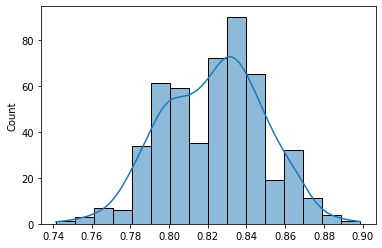

In [75]:
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

X = df_train_cleaned.drop('Survived', axis=1).copy()
y = df_train_cleaned.Survived.copy()

cv = RepeatedKFold(n_splits=5, n_repeats=100, random_state=654237)
m03 = LogisticRegression(penalty='l2')

scores = cross_val_score(m03, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

sns.histplot(x=scores, kde=True)

print('Cross Validation Score Mean after Repeated K-Fold: {:0.2f}%'.format(np.mean(scores)*100))
print('Cross Validation Score Std. Dev. after Repeated K-Fold: {:0.2f}'.format(np.std(scores)))

# Submission

In [87]:
test_data = pd.read_csv('data/test.csv')

test_data_cleaned = clean_data(test_data)

In [89]:
m03.fit(df_train_cleaned.drop('Survived', axis=1), df_train_cleaned.Survived)
m03_test_pred = m03.predict(test_data_cleaned)
m03_test_pred[0:10]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0], dtype=int64)

In [90]:
m03_test_pred_df = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': m03_test_pred})
m03_test_pred_df.to_csv('submissions/20220509_submission.csv', index=False)